In [1]:
import akshare as ak
import datetime
import random
import  torch
import os
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from tqdm import tqdm
import mplfinance as mpf
import numpy as np
import pandas as pd
from ptflops import get_model_complexity_info

In [2]:
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch()

In [3]:
#研究单只股票600976
code = '600976'
code1 = '002648'
code2 = '603393'
#股票的起始日期位2004年4月19日
start_date = '20040419'
start_date1 = '20111228'
start_date2 = '20160912'
# 使用每两周的数据来进行判断第二天的涨跌
tau=60
period_time=5
#使用振幅，涨跌幅，换手率来推测
element = 4
#今日日期
today = datetime.datetime.now().strftime('%Y%m%d')

#机器学习参数,前2560个样本用于训练
batch_size = 32
train_size = 0.8
learning_rate = 0.001

In [4]:
#将今日日期存入到文本中
date = open('last_date.txt', mode='r')
try:
    last_date = date.read()
finally:
    date.close
if last_date != today:
    date = open('last_date.txt', mode='w')
    date.write(today)
    date.close()

In [5]:
#调用接口，查找单只股票的历史纪录
stock_zh_a_hist_600976 = ak.stock_zh_a_hist(symbol=code, period="daily", start_date=start_date, end_date=today, adjust="")
stock_zh_a_hist_002648 = ak.stock_zh_a_hist(symbol=code1, period="daily", start_date=start_date1, end_date=today, adjust="")
stock_zh_a_hist_603393 = ak.stock_zh_a_hist(symbol=code2, period="daily", start_date=start_date2, end_date=today, adjust="")

In [6]:
stock_zh_a_hist_600976

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2004-04-19,15.68,16.47,17.30,15.68,146470,240988861.0,13.97,41.98,4.87,41.85
1,2004-04-20,16.17,15.59,16.32,15.50,49232,78109588.0,4.98,-5.34,-0.88,14.07
2,2004-04-21,15.50,15.59,15.76,15.10,29990,45992148.0,4.23,0.00,0.00,8.57
3,2004-04-22,15.40,15.63,15.70,15.40,14397,22394443.0,1.92,0.26,0.04,4.11
4,2004-04-23,15.68,15.46,15.75,15.10,15985,24559535.0,4.16,-1.09,-0.17,4.57
...,...,...,...,...,...,...,...,...,...,...,...
4414,2022-10-12,37.45,40.55,40.95,36.81,28236,110192581.0,11.11,8.77,3.27,1.85
4415,2022-10-13,40.00,41.63,42.25,39.88,34435,142404616.0,5.84,2.66,1.08,2.26
4416,2022-10-14,41.80,44.59,45.00,41.58,60252,265381712.0,8.22,7.11,2.96,3.95
4417,2022-10-17,46.48,47.76,49.05,45.92,103037,491987065.0,7.02,7.11,3.17,6.76


In [7]:
print(stock_zh_a_hist_600976.iloc(0)[59])

日期     2004-07-19
开盘           12.5
收盘          12.47
最高          12.67
最低           12.3
成交量          5536
成交额     6904686.0
振幅           2.96
涨跌幅          -0.4
涨跌额         -0.05
换手率          1.58
Name: 59, dtype: object


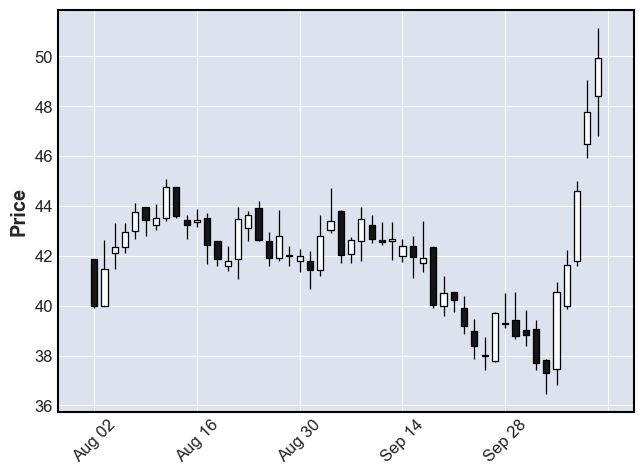

In [8]:
df = stock_zh_a_hist_600976.loc[:,('日期','开盘','收盘','最高','最低')]
df1 = stock_zh_a_hist_002648.loc[:,('日期','开盘','收盘','最高','最低')]
df2 = stock_zh_a_hist_603393.loc[:,('日期','开盘','收盘','最高','最低')]
df = df.rename(columns={'日期':'Date','开盘':'Open','收盘':'Close','最高':'High','最低':'Low'})
df1 = df1.rename(columns={'日期':'Date','开盘':'Open','收盘':'Close','最高':'High','最低':'Low'})
df2 = df2.rename(columns={'日期':'Date','开盘':'Open','收盘':'Close','最高':'High','最低':'Low'})
df.index=pd.to_datetime(df['Date'])
df1.index=pd.to_datetime(df1['Date'])
df2.index=pd.to_datetime(df2['Date'])
mpf.plot(df[-50:],type='candle')

In [9]:
T = len(stock_zh_a_hist_600976)
T1 = len(stock_zh_a_hist_002648)
T2 = len(stock_zh_a_hist_603393)

In [10]:
#构建数据
features = torch.zeros((T-tau-period_time+1,tau,element))
labels = torch.zeros(T-tau-period_time+1,period_time,element)
for i in range(tau):
    #features[:,i,0] = torch.tensor(stock_zh_a_hist_600976['振幅'][i:T-tau+i-1].values)
    #features[:,i,1] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][i:T-tau+i-1].values)
    #features[:,i,2] = torch.tensor(stock_zh_a_hist_600976['换手率'][i:T-tau+i-1].values)
    #labels[:] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][tau:T-1].apply(lambda x:1 if x >0 else -1).values)
    features[:,i,0] = torch.tensor(df['Open'][i:T-tau+i-period_time+1].values)
    features[:,i,1] = torch.tensor(df['Close'][i:T-tau+i-period_time+1].values)
    features[:,i,2] = torch.tensor(df['High'][i:T-tau+i-period_time+1].values)
    features[:,i,3] = torch.tensor(df['Low'][i:T-tau+i-period_time+1].values)
for i in range(period_time):
    labels[:,i,0] = torch.tensor(df['Open'][tau+i:T-period_time+i+1].values)
    labels[:,i,1] = torch.tensor(df['Close'][tau+i:T-period_time+i+1].values)
    labels[:,i,2] = torch.tensor(df['High'][tau+i:T-period_time+i+1].values)
    labels[:,i,3] = torch.tensor(df['Low'][tau+i:T-period_time+i+1].values)
features.requires_grad = True
labels.requires_grad = True
features = features.to('cuda')
labels=labels.to('cuda')

In [11]:
#构建数据
features1 = torch.zeros((T1-tau-period_time+1,tau,element))
labels1 = torch.zeros(T1-tau-period_time+1,period_time,element)
for i in range(tau):
    #features[:,i,0] = torch.tensor(stock_zh_a_hist_600976['振幅'][i:T-tau+i-1].values)
    #features[:,i,1] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][i:T-tau+i-1].values)
    #features[:,i,2] = torch.tensor(stock_zh_a_hist_600976['换手率'][i:T-tau+i-1].values)
    #labels[:] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][tau:T-1].apply(lambda x:1 if x >0 else -1).values)
    features1[:,i,0] = torch.tensor(df1['Open'][i:T1-tau+i-period_time+1].values)
    features1[:,i,1] = torch.tensor(df1['Close'][i:T1-tau+i-period_time+1].values)
    features1[:,i,2] = torch.tensor(df1['High'][i:T1-tau+i-period_time+1].values)
    features1[:,i,3] = torch.tensor(df1['Low'][i:T1-tau+i-period_time+1].values)
for i in range(period_time):
    labels1[:,i,0] = torch.tensor(df1['Open'][tau+i:T1-period_time+i+1].values)
    labels1[:,i,1] = torch.tensor(df1['Close'][tau+i:T1-period_time+i+1].values)
    labels1[:,i,2] = torch.tensor(df1['High'][tau+i:T1-period_time+i+1].values)
    labels1[:,i,3] = torch.tensor(df1['Low'][tau+i:T1-period_time+i+1].values)
features1.requires_grad = True
labels1.requires_grad = True
features1 = features1.to('cuda')
labels1=labels1.to('cuda')

In [12]:
#构建数据
features2 = torch.zeros((T2-tau-period_time+1,tau,element))
labels2 = torch.zeros(T2-tau-period_time+1,period_time,element)
for i in range(tau):
    #features[:,i,0] = torch.tensor(stock_zh_a_hist_600976['振幅'][i:T-tau+i-1].values)
    #features[:,i,1] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][i:T-tau+i-1].values)
    #features[:,i,2] = torch.tensor(stock_zh_a_hist_600976['换手率'][i:T-tau+i-1].values)
    #labels[:] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][tau:T-1].apply(lambda x:1 if x >0 else -1).values)
    features2[:,i,0] = torch.tensor(df2['Open'][i:T2-tau+i-period_time+1].values)
    features2[:,i,1] = torch.tensor(df2['Close'][i:T2-tau+i-period_time+1].values)
    features2[:,i,2] = torch.tensor(df2['High'][i:T2-tau+i-period_time+1].values)
    features2[:,i,3] = torch.tensor(df2['Low'][i:T2-tau+i-period_time+1].values)
for i in range(period_time):
    labels2[:,i,0] = torch.tensor(df2['Open'][tau+i:T2-period_time+i+1].values)
    labels2[:,i,1] = torch.tensor(df2['Close'][tau+i:T2-period_time+i+1].values)
    labels2[:,i,2] = torch.tensor(df2['High'][tau+i:T2-period_time+i+1].values)
    labels2[:,i,3] = torch.tensor(df2['Low'][tau+i:T2-period_time+i+1].values)
features2.requires_grad = True
labels2.requires_grad = True
features2 = features2.to('cuda')
labels2=labels2.to('cuda')

In [13]:
# current_day_data = torch.zeros((tau,element))

# current_day_data[:,0] = torch.tensor(stock_zh_a_hist_600976['振幅'][T-tau:T].values)
# current_day_data[:,1] = torch.tensor(stock_zh_a_hist_600976['涨跌幅'][T-tau:T].values)
# current_day_data[:,2] = torch.tensor(stock_zh_a_hist_600976['换手率'][T-tau:T].values)
current_day_data = torch.zeros((tau,element))

current_day_data[:,0] = torch.tensor(df['Open'][T-tau:T].values)
current_day_data[:,1] = torch.tensor(df['Close'][T-tau:T].values)
current_day_data[:,2] = torch.tensor(df['High'][T-tau:T].values)
current_day_data[:,3] = torch.tensor(df['Low'][T-tau:T].values)
current_day_data = current_day_data.to('cuda')

current_day_data1 = torch.zeros((tau,element))

current_day_data1[:,0] = torch.tensor(df1['Open'][T1-tau:T1].values)
current_day_data1[:,1] = torch.tensor(df1['Close'][T1-tau:T1].values)
current_day_data1[:,2] = torch.tensor(df1['High'][T1-tau:T1].values)
current_day_data1[:,3] = torch.tensor(df1['Low'][T1-tau:T1].values)
current_day_data1 = current_day_data1.to('cuda')

current_day_data2 = torch.zeros((tau,element))

current_day_data2[:,0] = torch.tensor(df2['Open'][T2-tau:T2].values)
current_day_data2[:,1] = torch.tensor(df2['Close'][T2-tau:T2].values)
current_day_data2[:,2] = torch.tensor(df2['High'][T2-tau:T2].values)
current_day_data2[:,3] = torch.tensor(df2['Low'][T2-tau:T2].values)
current_day_data2 = current_day_data2.to('cuda')

In [14]:
features = torch.cat((features1,features),0)
features = torch.cat((features2,features),0)
labels = torch.cat((labels1,labels),0)
labels = torch.cat((labels2,labels),0)

In [15]:
from torch.utils.data import Dataset
 
class MyDataSet(Dataset):
    def __init__(self, features, labels,start,end):
        self.features = features[start:end]
        self.labels = labels[start:end]
 
    def __getitem__(self, index):

        return self.features[index],self.labels[index]
 
    def __len__(self):
        return len(self.features)
dataset = MyDataSet(features,labels,0,len(features))
train_size=int(train_size*len(dataset))
test_size=len(dataset)-train_size
train_datasets, test_datasets = torch.utils.data.random_split(dataset, [train_size, test_size])

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size, drop_last=True,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size, drop_last=True,shuffle = False)

In [17]:
# 初始化网络权重的函数
class NeuralModel(nn.Module):
    def __init__(self, hidden_units = 256, hidden_linear_units = 1024):
        super(NeuralModel,self).__init__()
        self.hidden_units =  hidden_units
        self.hidden_linear_units = hidden_linear_units
        self.lstm =nn.LSTM(input_size=element, hidden_size=hidden_units, num_layers=3, batch_first=True)
        self.linear1 = nn.Linear(hidden_units*tau,hidden_linear_units)
        self.linear2 = nn.Linear(hidden_linear_units, period_time*element)
        
        
    def forward(self, x):
        #x = torch.reshape(x,(-1,tau*element))
        result,_ = self.lstm(x)
        result = self.linear1(result.reshape(-1,self.hidden_units*tau))
        result = self.linear2(result)
        return result

model = NeuralModel().to('cuda')
loss_fn = nn.MSELoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(),betas=(0.9, 0.999) ,lr=learning_rate)

In [18]:
Train_loss_list = []
Test_loss_list = []
def train_loop(dataloader, model, loss_fn, optimizer):
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss= 0
    #correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.view(batch_size,-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        #correct += sum(i>0 for i in (pred*y).view(-1)).item()
        optimizer.step()
        
    train_loss/= num_batches
    Train_loss_list.append(train_loss)
    #correct /= size*period_time
    #print(f"Train_loss: {train_loss:>7f},Train Error: \n Accuracy: {(100*correct):>0.1f}% ")
    print(f"Train_loss: {train_loss:>7f}")

def test_loop(dataloader, model, loss_fn):
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    #correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.view(batch_size,-1)).item()
            #correct += sum(i>0 for i in (pred*y).view(-1)).item()

    test_loss /= num_batches
    Test_loss_list.append(test_loss)
    #correct /= size*period_time
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [19]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train_loss: 30.779351
Test Error: 
 Avg loss: 10.618799 

Epoch 2
-------------------------------
Train_loss: 6.827534
Test Error: 
 Avg loss: 6.551084 

Epoch 3
-------------------------------
Train_loss: 5.141031
Test Error: 
 Avg loss: 5.126749 

Epoch 4
-------------------------------
Train_loss: 3.930993
Test Error: 
 Avg loss: 2.895040 

Epoch 5
-------------------------------
Train_loss: 3.279626
Test Error: 
 Avg loss: 12.459719 

Epoch 6
-------------------------------
Train_loss: 3.175066
Test Error: 
 Avg loss: 3.029113 

Epoch 7
-------------------------------
Train_loss: 3.623454
Test Error: 
 Avg loss: 6.396090 

Epoch 8
-------------------------------
Train_loss: 3.284841
Test Error: 
 Avg loss: 3.232346 

Epoch 9
-------------------------------
Train_loss: 3.208411
Test Error: 
 Avg loss: 4.666351 

Epoch 10
-------------------------------
Train_loss: 3.312959
Test Error: 
 Avg loss: 3.265797 

Epoch 11
---------------------------

In [39]:
Y = model(current_day_data2).reshape(period_time,element)

In [40]:
Y

tensor([[23.7036, 24.0294, 24.3412, 23.3640],
        [24.1931, 24.3863, 24.7629, 23.9356],
        [24.3619, 24.5289, 24.9285, 23.9702],
        [24.5154, 24.3109, 24.6817, 23.8222],
        [24.2192, 24.3945, 24.8539, 23.8998]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [25]:
X = np.array((Y.cpu()).detach())
X = pd.DataFrame(X)
col = ['Open','Close','High','Low']
X.columns = col
X

,Open,Close,High,Low
0,49.977032,51.143654,51.943630,49.448650
1,51.046890,51.517426,52.745007,50.499542
2,51.384174,51.654102,52.801163,50.367477
3,51.657150,51.241318,52.438259,50.290455
4,51.205959,50.985161,52.164680,50.078938


In [26]:
current_day = datetime.datetime.now()
Time = []
for i in range(period_time):
    next_n = current_day + datetime.timedelta(days =i+1)
    next_n = str(next_n).split()[0]
    Time.append(next_n)
X['Time'] = Time

In [27]:
X

,Open,Close,High,Low,Time
0,49.977032,51.143654,51.943630,49.448650,2022-10-19
1,51.046890,51.517426,52.745007,50.499542,2022-10-20
2,51.384174,51.654102,52.801163,50.367477,2022-10-21
3,51.657150,51.241318,52.438259,50.290455,2022-10-22
4,51.205959,50.985161,52.164680,50.078938,2022-10-23


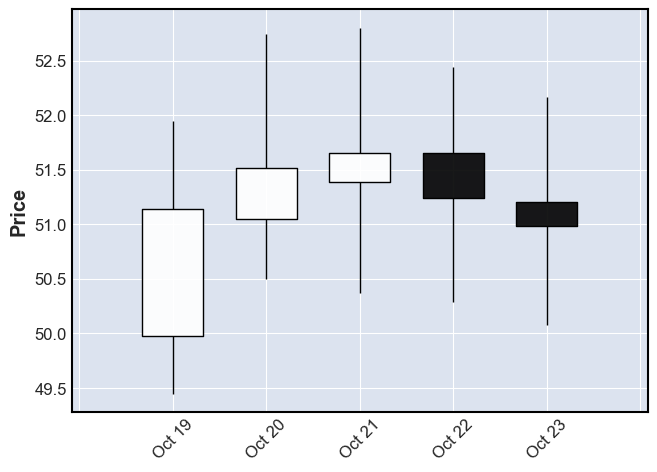

In [28]:
X.index=pd.to_datetime(X['Time'])
mpf.plot(X,type='candle')

# 停止运行

In [31]:
cmp_pred = model(features)[:,0].cpu()
cmp_pred = cmp_pred.detach()
cmp_real = torch.tensor(df['Open'][T-len(cmp_pred):].values)

RuntimeError: CUDA out of memory. Tried to allocate 8.02 GiB (GPU 0; 8.00 GiB total capacity; 2.92 GiB already allocated; 1.22 GiB free; 4.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
cmp_pred_close = model(features)[:,1].cpu()
cmp_pred_close= cmp_pred_close.detach()
cmp_real_close = torch.tensor(df['Close'][T-len(cmp_pred_close):].values)
plt.plot(list(range(len(cmp_real_close))),cmp_pred,label='Real_Close')
plt.plot(list(range(len(cmp_pred_close))),cmp_pred_close,label='Pred_Close')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(cmp_real))),cmp_real,label='Real_Open')
plt.plot(list(range(len(cmp_pred))),cmp_pred,label='Pred_Open')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [32]:
cmp_pred_high = model(features)[:,2].cpu()
cmp_pred_high= cmp_pred_high.detach()
cmp_real_high = torch.tensor(df['High'][T-len(cmp_pred_high):].values)
plt.plot(list(range(len(cmp_real_high))),cmp_pred,label='Real_High')
plt.plot(list(range(len(cmp_pred_high))),cmp_pred_close,label='Pred_High')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 8.02 GiB (GPU 0; 8.00 GiB total capacity; 2.97 GiB already allocated; 1.22 GiB free; 4.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

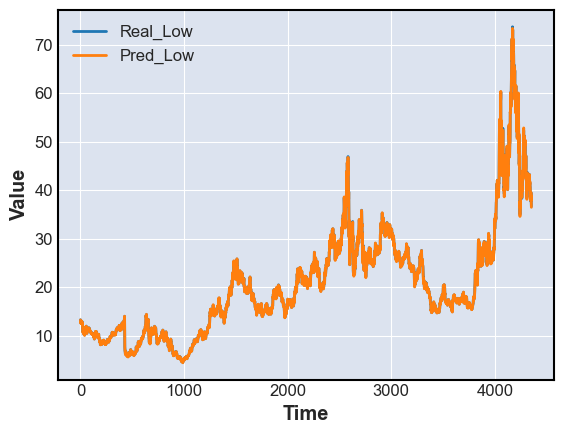

In [28]:
cmp_pred_low = model(features)[:,3].cpu()
cmp_pred_low= cmp_pred_low.detach()
cmp_real_low = torch.tensor(df['Low'][T-len(cmp_pred_low):].values)
plt.plot(list(range(len(cmp_real_low))),cmp_pred,label='Real_Low')
plt.plot(list(range(len(cmp_pred_low))),cmp_pred_close,label='Pred_Low')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [29]:
print(cmp_real)
print(cmp_real_close)
print(cmp_real_high)
print(cmp_real_low)

tensor([11.9900, 12.0000, 11.7000,  ..., 40.0000, 41.8000, 46.4800],
       dtype=torch.float64)
tensor([11.7800, 11.6600, 11.7800,  ..., 41.6300, 44.5900, 47.7600],
       dtype=torch.float64)
tensor([12.0100, 12.0000, 11.8500,  ..., 42.2500, 45.0000, 49.0500],
       dtype=torch.float64)
tensor([11.7500, 11.5900, 11.5800,  ..., 39.8800, 41.5800, 45.9200],
       dtype=torch.float64)


In [30]:
torch.save(model,'LSTM_10_7.pt')
model1 =  NeuralModel()
model1 = torch.load('LSTM_10_7.pt')

In [31]:
model1

NeuralModel(
  (lstm): LSTM(4, 128, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=7680, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=20, bias=True)
)